## Introduction:
You can use this ipython notebook as a template for the rest of the homework.

### 0. Basic Useful Setups & Read MNIST using Keras

In [1]:
### Basic setups
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('./models/')
# Enable automatic reload of libraries
%load_ext autoreload
# All modules are reloaded before every comment
%autoreload 2
import keras
from utils import load_mnist
(x_train, y_train), (x_test, y_test) = load_mnist()
from keras.utils.vis_utils import plot_model # can be used to plot the model into a png file.

/media/qiaojun/disk/Qiaojun/virtualenv/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [2]:
#x_train_1 = np.reshape(x_train,(-1,28*28))
y_train_1 = np.where(y_train==1)[1]
#x_test_1 = np.reshape(x_test,(-1,28*28))
y_test_1 = np.where(y_test==1)[1]
x_train = np.squeeze(np.stack((x_train,)*3,axis = 3), axis=-1)
x_test = np.squeeze(np.stack((x_test,)*3,axis = 3), axis=-1)

In [3]:
x_train_VGG = np.zeros((60000,224,224,3),dtype = np.float32)
for index in range(60000):
    x_train_VGG[index,:,:,:] = cv2.resize(x_train[index,:,:,:],(224,224))

x_test_VGG = np.zeros((10000,224,224,3),dtype = np.float32)
for index in range(10000):
    x_test_VGG[index,:,:,:] = cv2.resize(x_test[index,:,:,:],(224,224))


### 1. Convolutional Neural Network

### 1.1. LetNet Model

In [3]:
from LeNet import LeNet
NUM_CLASSES = 10
model = LeNet(num_classes = NUM_CLASSES)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
# You can save the model by specifying a path
# modelPath = ____
# model.save(modelPath)

# You can also print out the model by typing
model.summary()

# You can plot the model into a png file and use it in your report.
pngModelPath = "images/LeNet.png"
# plot(model, to_file=pngModelPath, show_shapes=True)
plot_model(model, to_file=pngModelPath, show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 28, 28, 20)        520       
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 14, 14, 20)        0         
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 14, 14, 50)        25050     
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 7, 7, 50)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2450)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 500)               1225500   
__________

In [4]:
# train model
BATCH_SIZE = 128
MAX_EPOCH = 12

model.fit(x_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=MAX_EPOCH,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 9s 149us/step - loss: 0.1833 - acc: 0.9444 - val_loss: 0.0517 - val_acc: 0.9832
Epoch 2/12
60000/60000 [==============================] - 3s 43us/step - loss: 0.0462 - acc: 0.9854 - val_loss: 0.0464 - val_acc: 0.9830
Epoch 3/12
60000/60000 [==============================] - 3s 44us/step - loss: 0.0307 - acc: 0.9904 - val_loss: 0.0369 - val_acc: 0.9882
Epoch 4/12
60000/60000 [==============================] - 3s 46us/step - loss: 0.0220 - acc: 0.9932 - val_loss: 0.0245 - val_acc: 0.9916
Epoch 5/12
60000/60000 [==============================] - 3s 42us/step - loss: 0.0169 - acc: 0.9947 - val_loss: 0.0224 - val_acc: 0.9927
Epoch 6/12
60000/60000 [==============================] - 3s 45us/step - loss: 0.0120 - acc: 0.9964 - val_loss: 0.0204 - val_acc: 0.9930
Epoch 7/12
60000/60000 [==============================] - 3s 43us/step - loss: 0.0099 - acc: 0.9969 - val_loss: 0.0200 - val_ac

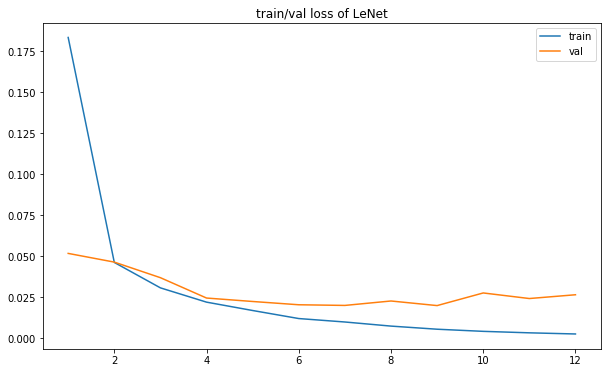

In [10]:
train_loss_LeNet = [0.1833,0.0462,0.0307,0.0220,0.0169,0.0120,0.0099,0.0074,0.0055,0.0042,0.0033,0.0026]
val_loss_LeNet = [0.0517,0.0464,0.0369,0.0245,0.0224,0.0204,0.0200,0.0227,0.0199,0.0276,0.0242,0.0265]
plt.figure(figsize=(10,6))
plt.plot(range(1,len(train_loss_LeNet)+1),train_loss_LeNet)
plt.plot(range(1,len(val_loss_LeNet)+1),val_loss_LeNet)
plt.legend(['train','val'])
plt.title('train/val loss of LeNet')
plt.show()

### 1.2. VGG16

In [4]:
# train model
BATCH_SIZE = 128
MAX_EPOCH = 12

from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
import numpy as np

# create the base pre-trained model
base_model = VGG16(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(128, activation='relu')(x)
# and a logistic layer -- let's say we have 10 classes
predictions = Dense(10, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
# model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
# You can also print out the model by typing
model.summary()

# You can plot the model into a png file and use it in your report.
#pngModelPath = "images/VGG16.png"
# plot(model, to_file=pngModelPath, show_shapes=True)
#plot_model(model, to_file=pngModelPath, show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [5]:
model.fit(x_train_VGG, y_train,
          batch_size=BATCH_SIZE,
          epochs=MAX_EPOCH,
          verbose=1,
          validation_data=(x_test_VGG, y_test))
score = model.evaluate(x_test_VGG, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 667s 11ms/step - loss: 1.0711 - acc: 0.7268 - val_loss: 0.5223 - val_acc: 0.8770
Epoch 2/12
60000/60000 [==============================] - 693s 12ms/step - loss: 0.3962 - acc: 0.9013 - val_loss: 0.2974 - val_acc: 0.9251
Epoch 3/12
60000/60000 [==============================] - 865s 14ms/step - loss: 0.2664 - acc: 0.9315 - val_loss: 0.2245 - val_acc: 0.9406
Epoch 4/12
60000/60000 [==============================] - 823s 14ms/step - loss: 0.2087 - acc: 0.9439 - val_loss: 0.1741 - val_acc: 0.9551
Epoch 5/12
60000/60000 [==============================] - 931s 16ms/step - loss: 0.1760 - acc: 0.9512 - val_loss: 0.1817 - val_acc: 0.9447
Epoch 6/12
60000/60000 [==============================] - 843s 14ms/step - loss: 0.1550 - acc: 0.9566 - val_loss: 0.1406 - val_acc: 0.9596
Epoch 7/12
60000/60000 [==============================] - 940s 16ms/step - loss: 0.1398 - acc: 0.9609 - val_loss: 0.

In [6]:
for layer in model.layers[-6:]:
    layer.trainable = True
from keras.optimizers import SGD
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=SGD(lr=0.0001, momentum=0.9),
              metrics=['accuracy'])
model.fit(x_train_VGG, y_train,
          batch_size=BATCH_SIZE,
          epochs=MAX_EPOCH,
          verbose=1,
          validation_data=(x_test_VGG, y_test))
score = model.evaluate(x_test_VGG, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 757s 13ms/step - loss: 0.0787 - acc: 0.9759 - val_loss: 0.0656 - val_acc: 0.9785
Epoch 2/12
60000/60000 [==============================] - 723s 12ms/step - loss: 0.0560 - acc: 0.9824 - val_loss: 0.0531 - val_acc: 0.9831
Epoch 3/12
60000/60000 [==============================] - 785s 13ms/step - loss: 0.0472 - acc: 0.9851 - val_loss: 0.0472 - val_acc: 0.9851
Epoch 4/12
60000/60000 [==============================] - 741s 12ms/step - loss: 0.0416 - acc: 0.9875 - val_loss: 0.0434 - val_acc: 0.9860
Epoch 5/12
60000/60000 [==============================] - 801s 13ms/step - loss: 0.0371 - acc: 0.9883 - val_loss: 0.0416 - val_acc: 0.9871
Epoch 6/12
60000/60000 [==============================] - 740s 12ms/step - loss: 0.0335 - acc: 0.9901 - val_loss: 0.0409 - val_acc: 0.9878
Epoch 7/12
60000/60000 [==============================] - 801s 13ms/step - loss: 0.0309 - acc: 0.9909 - val_loss: 0.

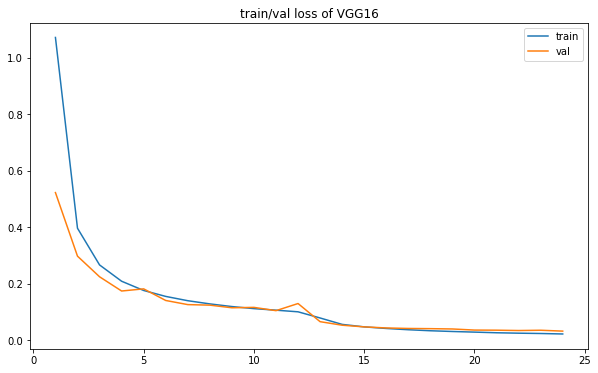

In [11]:
train_loss_VGG = [1.0711,0.3962,0.2664,0.2087,0.1760,0.1550,0.1398,0.1285,0.1191,0.1118,0.1063,0.1005,0.0787,0.0560,0.0472,0.0416,0.0371,0.0335,0.0309,0.0287,0.0264,0.0249,0.0238,0.0221]
val_loss_VGG = [0.5223,0.2974,0.2245,0.1741,0.1817,0.1406,0.1260,0.1241,0.1148,0.1162,0.1046,0.1298,0.0656,0.0531,0.0472,0.0434,0.0416,0.0409,0.0398,0.0359,0.0355,0.0343,0.0353,0.0322]
plt.figure(figsize=(10,6))
plt.plot(range(1,len(train_loss_VGG)+1),train_loss_VGG)
plt.plot(range(1,len(val_loss_VGG)+1),val_loss_VGG)
plt.legend(['train','val'])
plt.title('train/val loss of VGG16')
plt.show()

### 2. 1-Nearest Neighbor

Using the raw pixel values (28 × 28) as feature vector, use 1-Nearest Neighbor to train a model and report its performance on the test set and the confusion matrix. Also report other details of the experiments like the distance functions used, prototype selection (if you have used), etc.

Use euclidean_distance (l2)

In [63]:
from sklearn import neighbors

# the number of neighbors
n_neighbors = 1

# n_neighbors=5, weights=’uniform’, algorithm=’auto’, p=2, metric=’minkowski’, n_jobs=1
# weights: ‘uniform’, ‘distance’
# p: distance norm
clf = neighbors.KNeighborsClassifier(n_neighbors, weights='uniform', n_jobs=-1)
clf.fit(x_train_1, y_train_1)

y_predict_1nn_1 = clf.predict(x_test_1)
acc_1nn_1 = sum(y_predict_1nn_1 == y_test_1)/len(y_test_1)
print("Test accuracy of 1-Nearest Neighbor: %.3f"%acc_1nn_1)
confusion_matrix(y_test_1, y_predict_1nn_1, labels=range(10))

Test accuracy of 1-Nearest Neighbor: 0.969


array([[ 973,    1,    1,    0,    0,    1,    3,    1,    0,    0],
       [   0, 1129,    3,    0,    1,    1,    1,    0,    0,    0],
       [   7,    6,  992,    5,    1,    0,    2,   16,    3,    0],
       [   0,    1,    2,  970,    1,   19,    0,    7,    7,    3],
       [   0,    7,    0,    0,  944,    0,    3,    5,    1,   22],
       [   1,    1,    0,   12,    2,  860,    5,    1,    6,    4],
       [   4,    2,    0,    0,    3,    5,  944,    0,    0,    0],
       [   0,   14,    6,    2,    4,    0,    0,  992,    0,   10],
       [   6,    1,    3,   14,    5,   13,    3,    4,  920,    5],
       [   2,    5,    1,    6,   10,    5,    1,   11,    1,  967]])

Use manhattan_distance (l1)

In [65]:
from sklearn import neighbors
n_neighbors = 1
clf = neighbors.KNeighborsClassifier(n_neighbors, p=1, n_jobs=-1)
clf.fit(x_train_1, y_train_1)
y_predict_1nn_2 = clf.predict(x_test_1)
acc_1nn_2 = sum(y_predict_1nn_2 == y_test_1)/len(y_test_1)
print("Test accuracy of 1-Nearest Neighbor: %.3f"%acc_1nn_2)
confusion_matrix(y_test_1, y_predict_1nn_2, labels=range(10))

Test accuracy of 1-Nearest Neighbor: 0.963


array([[ 973,    2,    1,    0,    0,    1,    2,    1,    0,    0],
       [   0, 1129,    3,    0,    1,    1,    1,    0,    0,    0],
       [   9,    8,  987,    6,    1,    0,    2,   17,    2,    0],
       [   0,    2,    4,  965,    1,   21,    0,    9,    4,    4],
       [   1,    9,    0,    0,  937,    0,    3,    4,    1,   27],
       [   2,    1,    0,   17,    2,  848,    9,    1,    5,    7],
       [   5,    2,    1,    0,    2,    5,  943,    0,    0,    0],
       [   0,   20,    4,    2,    4,    0,    0,  989,    0,    9],
       [   9,    5,    6,   21,    4,   18,    3,    4,  894,   10],
       [   1,    5,    1,    7,   13,    5,    1,    9,    1,  966]])

### 3. Support Vector Machines

Using the same feature vector, use SVM to train a model and report its performance on the test set and the confusion matrix. Report other relevant details of the experiments.

In [ ]:
# C : float, optional (default=1.0)    
#   Penalty parameter C of the error term.
# kernel : string, optional (default=’rbf’)
#   Specifies the kernel type to be used in the algorithm. 
#   It must be one of ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’ or a callable. 
#   If none is given, ‘rbf’ will be used.
# degree : int, optional (default=3)   
#   Degree of the polynomial kernel function (‘poly’). Ignored by all other kernels.
# gamma : float, optional (default=’auto’)
#   Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’. If gamma is ‘auto’ then 1/n_features will be used instead.

#SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
#    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
#    max_iter=-1, probability=False, random_state=None, shrinking=True,
#    tol=0.001, verbose=False)

Use Radial basis function(RBF) kernel

In [67]:
from sklearn.svm import SVC
clf = SVC()
clf.fit(x_train_1, y_train_1) 
y_predict_SVM_1 = clf.predict(x_test_1)
acc_SVM_1 = sum(y_predict_SVM_1 == y_test_1)/len(y_test_1)
print("Test accuracy of Support Vector Machines: %.3f"%acc_SVM_1)
confusion_matrix(y_test_1, y_predict_SVM_1, labels=range(10))

Test accuracy of Support Vector Machines: 0.945


array([[ 967,    0,    2,    0,    0,    5,    4,    1,    1,    0],
       [   0, 1121,    2,    2,    0,    1,    4,    1,    4,    0],
       [   9,    1,  961,    9,   10,    1,   13,    9,   17,    2],
       [   1,    1,   15,  951,    1,   15,    1,   10,   11,    4],
       [   1,    1,    7,    0,  938,    0,    7,    2,    2,   24],
       [   7,    4,    5,   30,    7,  810,   12,    2,   10,    5],
       [   9,    3,    4,    1,    5,    9,  926,    0,    1,    0],
       [   2,   13,   22,    5,    8,    1,    0,  956,    3,   18],
       [   4,    7,    7,   14,    8,   23,   10,    6,  892,    3],
       [   8,    7,    0,   12,   31,    6,    1,   13,    7,  924]])

Use linear kernel

In [70]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(tol = 1e-3)
clf.fit(x_train_1, y_train_1) 
y_predict_SVM_2 = clf.predict(x_test_1)
acc_SVM_2 = sum(y_predict_SVM_2 == y_test_1)/len(y_test_1)
print("Test accuracy of Support Vector Machines: %.3f"%acc_SVM_2)
confusion_matrix(y_test_1, y_predict_SVM_2, labels=range(10))

Test accuracy of Support Vector Machines: 0.918


array([[ 951,    0,    1,    2,    2,   11,    5,    6,    1,    1],
       [   0, 1108,    4,    0,    0,    2,    4,    2,   15,    0],
       [   4,    5,  939,   10,   12,    5,    9,   12,   33,    3],
       [   5,    0,   30,  893,    3,   29,    3,   13,   25,    9],
       [   1,    5,    5,    0,  931,    0,    6,    2,    8,   24],
       [   8,    4,    3,   28,   20,  770,   17,    4,   30,    8],
       [   5,    3,    7,    3,   10,   13,  907,    3,    7,    0],
       [   1,    7,   28,    3,   10,    2,    1,  947,    2,   27],
       [   6,    9,    8,   13,   14,   32,   10,   11,  859,   12],
       [   5,   11,    3,    8,   50,   12,    0,   34,   12,  874]])

### 4. Spatial Pyramid Matching

In [111]:
%cd Image-recognition/
%run example.py
%cd ../

/media/qiaojun/disk/Qiaojun/Courses/COGS260/assignment/assignment2/hw2/Image-recognition
Training data load from None
Test data load from None
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Codebook Size: 100
Pyramid level: 1
Dense SIFT feature extraction
Building the codebook, it will take some time
Spatial Pyramid Matching encoding
Tuning hyper-parameters

Best parameters set found on development set:

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=100.0, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Grid scores on development set:

0.112 (+/-0.000) for {'C': 0.001, 'gamma': 0.001}
0.112 (+/-0.000) for {'C': 0.001, 'gamma': 0.01}
0.112 (+/-0.000) for {'C': 0.001, 'gamma': 0.1}
0.112 (+/-0.000) for {'C': 0.001, 'gamma': 1.0}
0.433 (+/-0.004) for {'C': 0.001, 'gamma': 10.0}
0.612 (+/-0.013) for {'C': 0.001, 'gamma': 100.0}
0.112 (+/-0.00

In [113]:
acc_SPM = 0.868

### 5. Deep Belief Nets

In [115]:
#Test accuracy of Deep Belief Nets: 0.985
# [[ 975    1    0    0    0    1    2    1    0    0]
# [   0 1129    2    1    0    1    1    0    1    0]
# [   6    0 1017    1    1    0    1    4    2    0]
# [   1    0    3  991    0    4    0    5    4    2]
# [   2    0    2    0  957    0    5    1    0   15]
# [   2    0    0    1    1  878    4    0    4    2]
# [   2    2    0    1    2    2  945    0    4    0]
# [   2    3    6    0    1    0    0 1009    1    6]
# [   2    1    1    2    0    1    0    1  962    4]
# [   2    3    1    2    3    2    0    3    3  990]]

### Evaluation

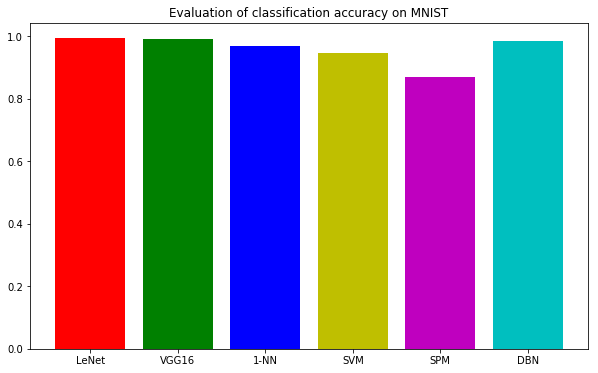

In [7]:
name_list = ['LeNet','VGG16','1-NN','SVM','SPM','DBN'] 
acc_list = [0.993, 0.990, 0.969, 0.945, 0.868, 0.985]  

plt.figure(figsize=(10,6))
plt.bar(range(len(name_list)), acc_list, color='rgbymc',tick_label=name_list)
plt.title('Evaluation of classification accuracy on MNIST')
plt.show() 